In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ========== STEP 1: Configuration ==========
IMG_HEIGHT, IMG_WIDTH = 96, 96
NUM_CLASSES = 43
data_dir = r"/Users/komalsaivulchi/Downloads/traffic-sign-detection-main/archive/Train"

# ========== STEP 2: Load & Resize Images ==========
images, labels = [], []

for class_id in range(NUM_CLASSES):
    class_path = os.path.join(data_dir, str(class_id))
    for img_name in os.listdir(class_path):
        img = cv2.imread(os.path.join(class_path, img_name))
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        images.append(img)
        labels.append(class_id)

X = np.array(images) / 255.0  # Normalize
y = to_categorical(labels, NUM_CLASSES)

# ========== STEP 3: Train-Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== STEP 4: Optional Class Weights ==========
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

# ========== STEP 5: Data Augmentation ==========
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# ========== STEP 6: Load Pretrained MobileNetV2 ==========
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ========== STEP 7: Compile Model ==========
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# ========== STEP 8: Train Top Layers First ==========
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stop]
)

# ========== STEP 9: Fine-Tune (Unfreeze last few layers) ==========
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=15,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stop]
)

# ========== STEP 10: Evaluate ==========
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Final Test Accuracy: {acc:.4f}")

# ========== STEP 11: Save Model ==========



/Users/komalsaivulchi/Downloads/traffic-sign-detection-main/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15


/Users/komalsaivulchi/Downloads/traffic-sign-detection-main/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 84s 83ms/step - accuracy: 0.1015 - loss: 3.6004 - val_accuracy: 0.4308 - val_loss: 2.0974
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - accuracy: 0.3297 - loss: 2.3336 - val_accuracy: 0.5561 - val_loss: 1.5794
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 75s 77ms/step - accuracy: 0.4163 - loss: 1.8800 - val_accuracy: 0.6104 - val_loss: 1.3342
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 78s 79ms/step - accuracy: 0.4820 - loss: 1.5999 - val_accuracy: 0.6593 - val_loss: 1.1729
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 86s 87ms/step - accuracy: 0.5130 - loss: 1.4473 - val_accuracy: 0.6808 - val_loss: 1.0656
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 96s 98ms/step - accuracy: 0.5586 - loss: 1.3025 - val_accuracy: 0.7019 - val_loss: 0.9847
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 90s 92ms/step - accuracy: 0.5707 - loss: 1.2064 - val_accuracy: 0.7198 - val_loss: 0.9193
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 89s 91ms/step - accuracy: 0.5958 - loss: 1.1109 - val_accurac

In [2]:
# ...existing code...
model.save("traffic_sign_mobilenetv2.h5")
print("✅ Model saved as traffic_sign_mobilenetv2.h5")
# ...existing code...

✅ Model saved as traffic_sign_mobilenetv2.h5


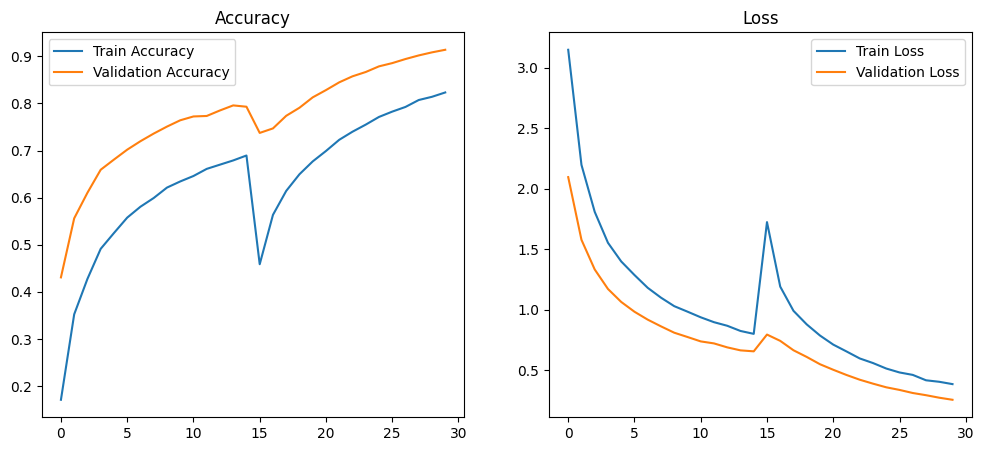

In [3]:
# Combine both training phases
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.show()


✅ Model Loaded Successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


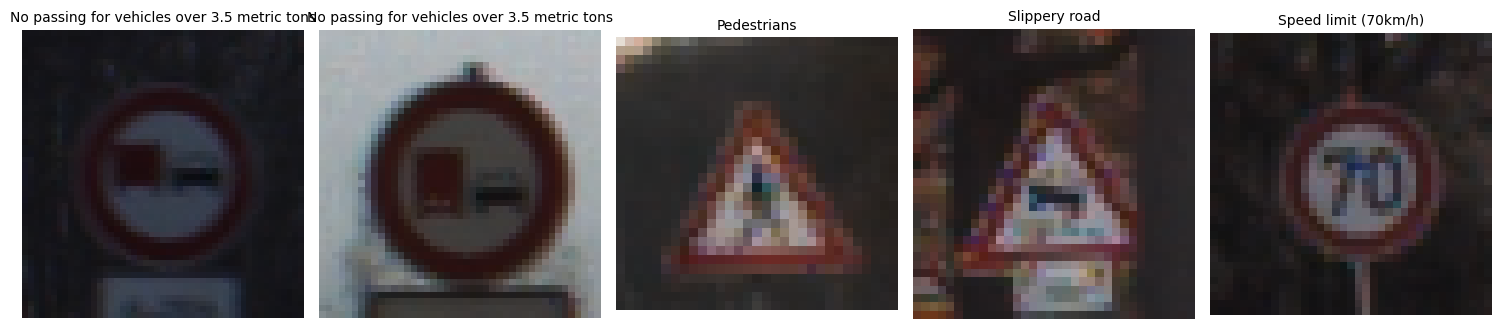

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/Users/komalsaivulchi/Downloads/traffic-sign-detection-main/MobileNet/traffic_sign_mobilenetv2.h5")
print("✅ Model Loaded Successfully!")

# Path to test directory
test_dir = r"/Users/komalsaivulchi/Downloads/traffic-sign-detection-main/archive/Test"

# Class labels (already provided by you)
class_labels = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

# Show 5 random test images
num_images = 5
test_images = random.sample(os.listdir(test_dir), num_images)

plt.figure(figsize=(15, 5))

for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, img_name)
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (96, 96))  # Resize as per model input
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    prediction = model.predict(img_input)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels.get(predicted_class, "Unknown")

    # Plot image and prediction
    plt.subplot(1, num_images, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{predicted_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


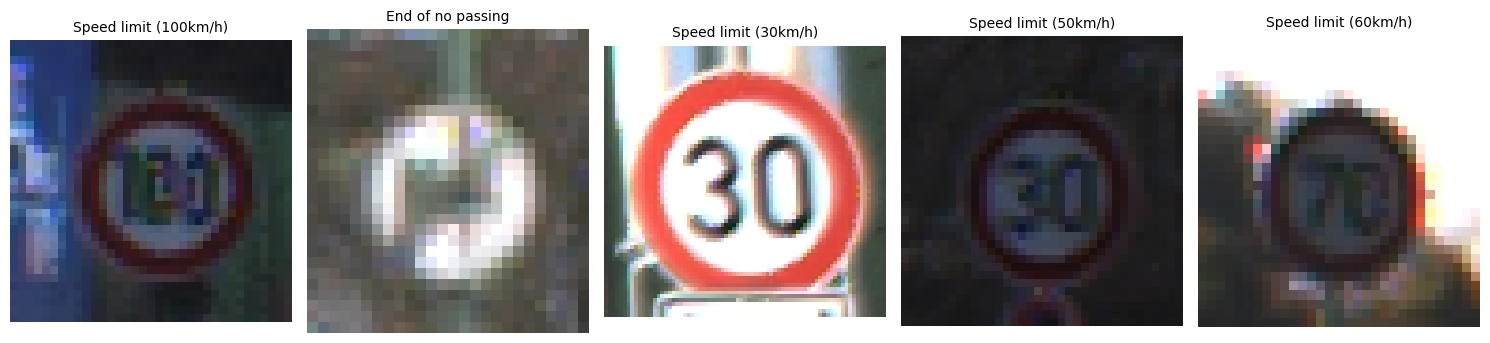

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/Users/komalsaivulchi/Downloads/traffic-sign-detection-main/MobileNet/traffic_sign_mobilenetv2.h5")

# Path to test directory
test_dir = r"/Users/komalsaivulchi/Downloads/traffic-sign-detection-main/archive/Test"

# Class labels (already provided by you)
class_labels = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

# Show 5 random test images
num_images = 5
test_images = random.sample(os.listdir(test_dir), num_images)

plt.figure(figsize=(15, 5))

for i, img_name in enumerate(test_images):
    img_path = os.path.join(test_dir, img_name)
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (96, 96))  # Resize as per model input
    img_input = img_resized / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    prediction = model.predict(img_input)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels.get(predicted_class, "Unknown")

    # Plot image and prediction
    plt.subplot(1, num_images, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{predicted_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
